In [1]:
WORKING_DIR = "./"
IMG_DIR = "./data/images/"

In [2]:
import pandas as pd

# adatok beolvasása és osztályozása
df = pd.read_csv(WORKING_DIR+"data/original_segmentations.csv")
df['has_ship'] = df['EncodedPixels'].notnull().astype(int)
df = df.drop(columns='EncodedPixels')
df.head()

,ImageId,has_ship
0,00003e153.jpg,0
1,0001124c7.jpg,0
2,000155de5.jpg,1
3,000194a2d.jpg,1
4,000194a2d.jpg,1


In [3]:
import cv2
import matplotlib.pyplot as plt

#képek betöltése
def load_img(img_id:str):
    img = cv2.imread(IMG_DIR+str(img_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [4]:
import numpy as np

#feature-k kiszámolása edge density és variance
def features(img_id:str):
    img = load_img(img_id)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    ratio = np.sum(edges > 0) / edges.size
    
    gray = gray /255.0
    variance = np.var(gray)
    return (ratio, variance)
    

In [5]:
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


tqdm.pandas() 

# mintavételezést használtam hogy ne tartson olyan sokáig, később persze lehet még bővíteni
df_sample = df.sample(10000, random_state=42)

df_sample[['ratio', 'variance']] = pd.DataFrame(
    df_sample['ImageId'].progress_apply(lambda x: features(x)).tolist(),
    index=df_sample.index
)
""" undersampling
df_0 = df_sample[df_sample["has_ship"] == 0]
df_1 = df_sample[df_sample["has_ship"] == 1]

df_0_downsampled = df_0.sample(len(df_1), random_state=42)

df_balanced = pd.concat([df_0_downsampled, df_1]).sample(frac=1, random_state=42)
"""

X = df_sample[["ratio", "variance"]]
y = df_sample["has_ship"]
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

100%|██████████| 10000/10000 [02:29<00:00, 66.76it/s]


In [6]:
import joblib

model = RandomForestClassifier(class_weight = "balanced", n_estimators=250, random_state=42)
model.fit(X_train, y_train)

model_name = "empty_filter_forest.pkl"

joblib.dump(model, WORKING_DIR+"data/cache/"+model_name)

print("Model saved as", model_name)


Model saved as empty_filter_forest.pkl


Accuracy: 0.742

Classification report:
               precision    recall  f1-score   support

           0       0.81      0.80      0.81      1342
           1       0.60      0.62      0.61       658

    accuracy                           0.74      2000
   macro avg       0.71      0.71      0.71      2000
weighted avg       0.74      0.74      0.74      2000



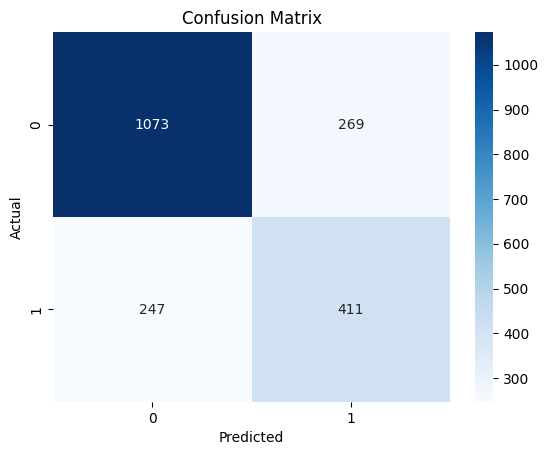

In [8]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print("Accuracy:", acc)
print("\nClassification report:\n", classification_report(y_test, y_pred))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()